# Homework 8:  Resampling methods

This homework assignment is designed to give you practice with bootstrapping and permutation tests.

You will need to download the **unrestricted_trimmed_1_7_2020_10_50_44.csv** file from the *Homework/hcp_data* folder in the class GitHub repository. 

This data is a portion of the [Human Connectome Project database](http://www.humanconnectomeproject.org/). It provides measures of cognitive tasks and brain morphology measuresments from 1206 participants. The full description of each variable is provided in the **HCP_S1200_DataDictionary_April_20_2018.csv** file in the *Homework/hcp_data* folder in the class GitHub repository.

---
## 1. Loading & Visualizing the Data (1 point)

Use the `setwd` and `read.csv` functions to load data from the **unrestricted_trimmed_1_7_2020_10_50_44.csv** file. 

(a) Using the tidyverse tools, make a new dataframe `d1` that only inclues the subject ID (`Subject`), gender (`Gender`, self reported at time of data collection), Flanker Task performance (`Flanker_Unadj`), total intracranial volume (`FS_IntraCranial_Vol`), total white matter volume (`FS_Tot_WM_Vol`), and total grey matter volume (`FS_Total_GM_Vol`) variables and remove all _na_ values.

Use the `head` function to look at the first few rows of each data frame. 

In [24]:
#Load packages
library(tidyverse)
library(ggplot2)
library(ISLR)
library(boot)

In [12]:
#Load data
setwd("C:/Users/MCT40/OneDrive - University of Pittsburgh/Classes/Spring2022/CMU_STATS/HOMEWORK")

hcp_data <- read.csv("hcp_data/unrestricted_trimmed_1_7_2020_10_50_44.csv")

hcp_data %>% 
    select(Subject, Gender, Flanker_Unadj, FS_IntraCranial_Vol, FS_Tot_WM_Vol, FS_Total_GM_Vol) %>%
    drop_na() -> d1

any(d1 == "n/a")

head(d1)

[1] FALSE

,Subject,Gender,Flanker_Unadj,FS_IntraCranial_Vol,FS_Tot_WM_Vol,FS_Total_GM_Vol
,<int>,<chr>,<dbl>,<dbl>,<int>,<int>
1,100206,M,130.42,1864518,543134,807245
2,100307,F,112.56,1512540,407292,664124
3,100408,M,121.18,1684117,500417,726206
4,100610,M,126.53,1816044,512946,762308
5,101006,F,101.85,1437868,429449,579632
6,101107,M,107.04,1512727,416995,665024


(b) Plot grey matter volume (x axis) against intracranial volume (y axis) and Gender (point color). 

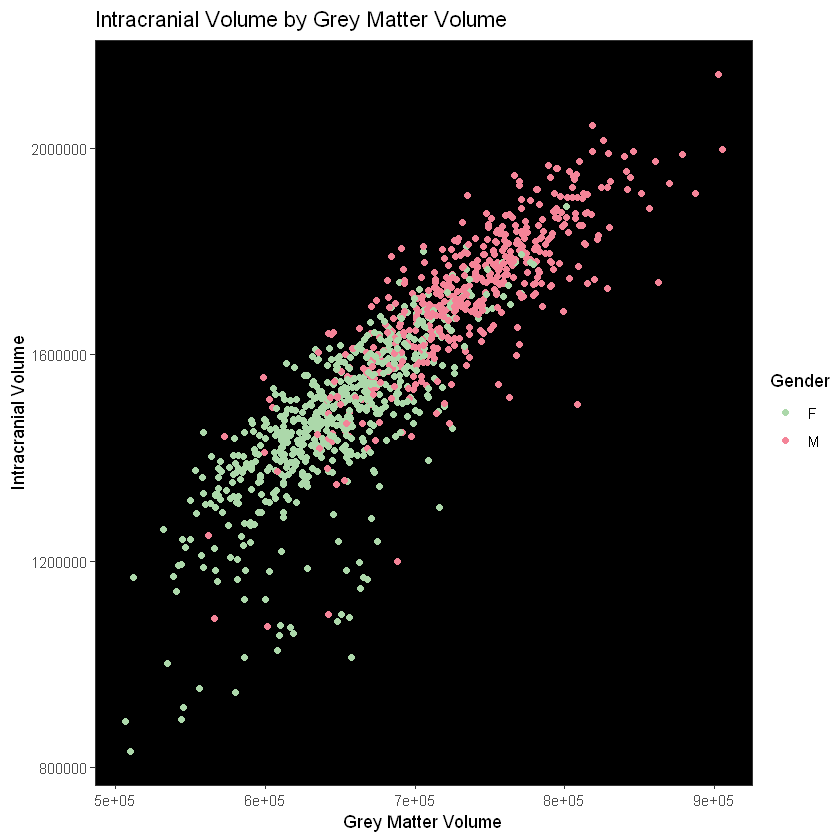

In [13]:
ggplot(d1, aes(FS_Total_GM_Vol, FS_IntraCranial_Vol, colour=Gender)) +
  geom_point() +
  theme_test() +
  labs(x = "Grey Matter Volume", y = "Intracranial Volume", title = "Intracranial Volume by Grey Matter Volume") +
  scale_color_manual(values = c("#ACD8AA", "#F48498")) +
  theme(panel.background = element_rect(fill = "black")) 


What patterns do you observe in the scatter plot?

> Females tend to have smaller overall grey matter volume and intracranial volume compared to men

> Additionally there appears to be a linear correlation between the two (grey matter and intracranial volume), which makes sense since if there's a bigger skull it's probably filled with grey/white matter. 

---
## 2. Logistic classifier (2 points)

We want to try predicting gender using the neural data you have loaded.

(a) Run a logisic regression model to predict gender from total white matter volume, total grey matter volume, and intracranial volume. 

In [35]:
#Make sure the outcome variable is a binary variable coded 0(female) and 1(male)
d1$Gender <- as.numeric(as.factor(d1$Gender))-1

#Run the log regression
Log_reg_hcp <- glm(Gender ~ FS_Tot_WM_Vol + FS_Total_GM_Vol + FS_IntraCranial_Vol, data= d1, family = binomial)
summary(Log_reg_hcp)



Call:
glm(formula = Gender ~ FS_Tot_WM_Vol + FS_Total_GM_Vol + FS_IntraCranial_Vol, 
    family = binomial, data = d1)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.7695  -0.6173  -0.1863   0.5997   3.2309  

Coefficients:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)         -2.262e+01  1.347e+00 -16.787  < 2e-16 ***
FS_Tot_WM_Vol        2.140e-06  3.059e-06   0.699    0.484    
FS_Total_GM_Vol      1.959e-05  3.145e-06   6.229 4.70e-10 ***
FS_IntraCranial_Vol  5.020e-06  1.177e-06   4.263 2.01e-05 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1534.13  on 1112  degrees of freedom
Residual deviance:  919.85  on 1109  degrees of freedom
AIC: 927.85

Number of Fisher Scoring iterations: 5


Which factors are signficantly associated with gender?

> Total grey matter volume (p <.001), and Intracranial volume (p<.001) are statistically related to gender.

(b) Estimate the prediction accuracy of your model (Note: this is the training set accuracy). Set your prediction threshold to 0.5.

In [22]:
# 2b) ##Can also  change the model to use the values in this matrix
threshold = 0.50
d1_predict = data.frame(predict(Log_reg_hcp, type = "response"))

## Rename the predicted values generated above to "predicted_prob" for ease of interpretability
colnames(d1_predict) = c('predicted_prob')
head(d1_predict)

# Make a list of "Incorrect" responses (coded as 0)
num_obs = nrow(d1)
d1_predict$predicted_binary=rep(0,num_obs)
d1_predict$predicted_binary[d1_predict$predicted_prob>threshold]= 1

# Look at the prediction accuracy in form of confusion matrix table
d1_conf = data.frame(d1_predict$predicted_binary, as.factor(d1$Gender))
colnames(d1_conf) = c('predicted', 'actual')
table(d1_conf)

#            actual
# predicted   0   1
# 0          516 110
# 1          0 397

## Abbreviated summary: 
## 516 predicted 0 actual F (true neg)
## 110 predicted 0 actual M (false neg)
## 90  predicted 1 actual F (false pos)
## 397 predicted 1 actual M (true pos)

## Calculate the general accuracy of the model's predictions: 
print(paste("Accuracy:",mean(d1_conf$predicted == d1_conf$actual)))


,predicted_prob
,<dbl>
1,0.97633865
2,0.24207122
3,0.75683279
4,0.92633475
5,0.04212663
6,0.24936028


         actual
predicted   0   1
        0 516 110
        1  90 397

[1] "Accuracy: 0.820305480682839"


What is the prediction accuracy for gender from the full model?


> The accuracy is 82.03% which is pretty good! 

---
## 3. Bootstrapped accuracy (3 points)

Use bootstrapping to estimate the confidence intervals of the _prediction accuracy_ of your model. Plot the histogram of the bootstrapped prediction accuracies and estimate the confidence intervals off of the standard deviation from the bootstrap.


[1] 0.8203055


[1] 0.8183306

[1] "lower bound:"


[1] 0.8180746

[1] "upper bound:"


[1] 0.8185867

ERROR: Error in hist(boot(d1, boot.fn, R = 1000)$t, xlab = "Model Accuracy", : non-numeric argument to binary operator


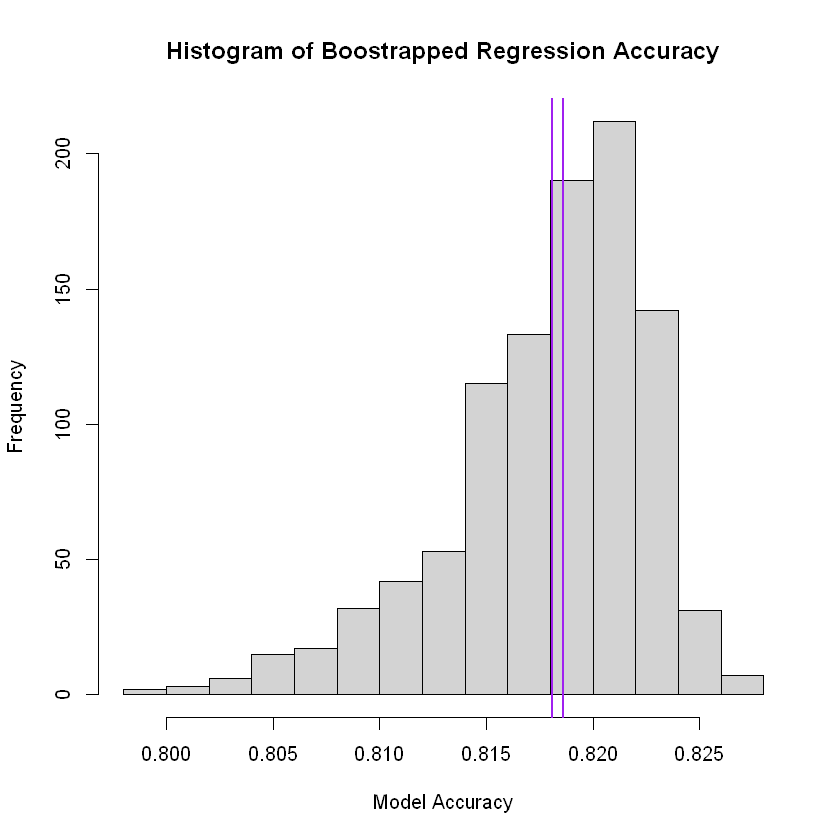

In [30]:
# 3 Boostraped accuracy
# install.packages("boot")
# install.packages("ISLR")
# library(ISLR)
# library(boot)
set.seed(33)

#write boostrapping function
boot.fn <- function(data, index){  
    #run the model on a subset
  Log_reg_hcp <- glm(Gender ~ FS_Tot_WM_Vol + FS_Total_GM_Vol + FS_IntraCranial_Vol, data, family = binomial, subset= index)

  #build predict data base with column #predicted_prob
  d1_predict = data.frame(predict(Log_reg_hcp,d1, type = "response"))
  colnames(d1_predict) = c('predicted_prob')
  
  # Make a list of "Incorrect" responses (coded as 0)
  num_obs = nrow(d1)
  d1_predict$predicted_binary=rep(0,num_obs)
  d1_predict$predicted_binary[d1_predict$predicted_prob>threshold]= 1
  
  # Look at the prediction accuracy in form of confusion matrix table
  d1_conf = data.frame(d1_predict$predicted_binary, as.factor(d1$Gender))
  colnames(d1_conf) = c('predicted', 'actual')
  
  ## Calculate the general accuracy of the model's predictions: 
  return(mean(d1_conf$predicted == d1_conf$actual))
}

#run bootstrapping function
print(boot.fn(d1, 1:1113))

##Run it with random resampling: 
boot_obj = boot(d1,boot.fn ,R=1000) #R=repetitions 
mean(boot_obj$t)
# print(boot_obj$t) #no need to print this in the homework output


  
  #confidence intervals
boot_mean <- mean(boot_obj$t)
boot_sd <- sd(boot_obj$t)
n <- nrow(d1)
se <- boot_sd/sqrt(n) 
CI <- 1.96 * se 
lower <- boot_mean-CI
upper <- boot_mean+CI

print("lower bound:")
lower

print("upper bound:")
upper

#plot histogram
hist(boot(d1,boot.fn ,R=1000)$t, xlab="Model Accuracy", main="Histogram of Boostrapped Regression Accuracy") +
  abline(v=c(lower, upper),col="purple",lwd=2)

How robust is the prediction accuracy of the full model?

> The model accuracy is quite robust because of the confidence interval range is very narrow. 

---
## 4. Permutation test for grey matter effects (3 points)

Now run a permutation test, with 1000 iterations, to evaluate how much grey matter volume contributes to the prediction accuracy. Compare the prediction accuracy of the full (unpermuted model) with the distribution of accuracies you get with a randomized grey matter volume term using a histogram (Hint: use the `abline` function to show the original accuracy on the histogram).

[1] 0.8055714

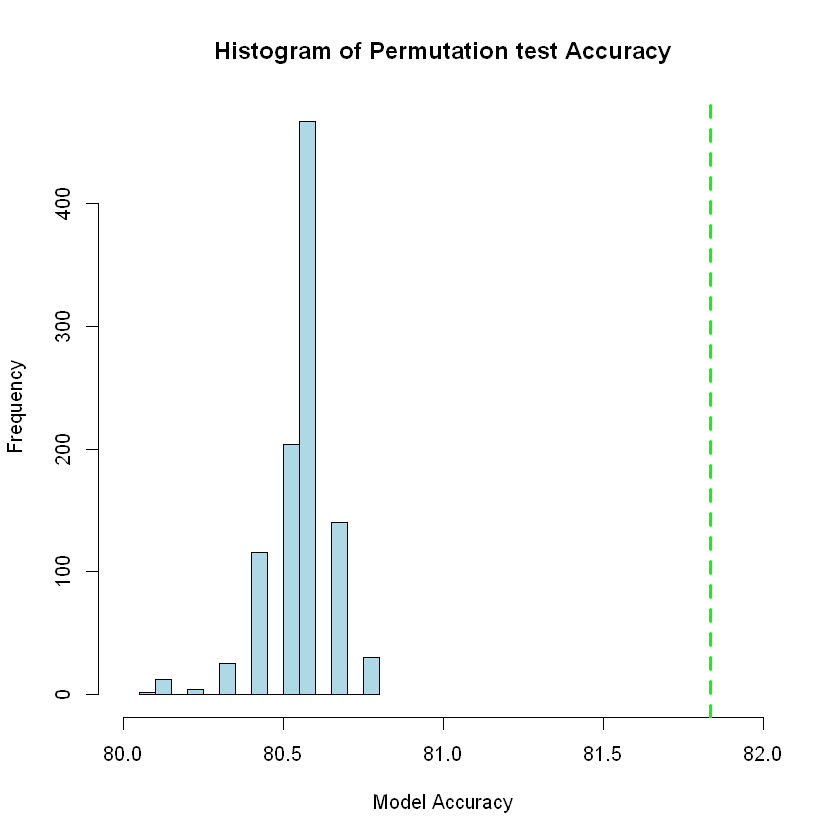

In [34]:
perm_d1 = d1 #want to preserve the non-permuted, true form of data!
num_obs = nrow(d1) 

# Set the number of iterations
R=1000

# Next make an output object to store the results
perm_acc=matrix(NA,nrow=R, ncol=1) #filling with nas at first

# Now just write a for loop where we scramble the observations
# in X using the sample() function. We'll scramble the observations in R different ways
for (i in 1:R){
  perm_d1$FS_Total_GM_Vol=d1$FS_Total_GM_Vol[sample(1113)] #randomize GM vol
  perm_acc[i]<- boot.fn(perm_d1, 1:1113) # then we get coefficients for linear model of shuffled horsepower to auto
}


# Take a look at the null distributions
perm_acc <- as.data.frame(perm_acc)
mean(perm_acc$V1)

#HIST
hist((perm_acc$V1*100), xlim=c(80,82), xlab="Model Accuracy", main="Histogram of Permutation test Accuracy", col="lightblue")
abline(v= boot_mean*100, col="green", lwd=3, lty=2)

How much does the grey matter volume influence the prediction accuracy of the model?

> Grey matter volume played an important influence on the model. You can see how much the accuracy of the model dropped when the variable was permuted. It dropped by a whole percentage point. 
 

---
## 5. Reflection (1 point)

Differentiate the bootstrap from a permutation test. Describe each and when is it appropriate use to each.

In my own words: 

 > Boostrapping allows for resampling with resampling, which allows us to explore different possible outcomes that may arise. This is helpful in answering question of reliability and replicability. 
    
 > Permutation testing allows you to determine the role of a specific variable to answer a question about that variable. And allows you to build essentially null distributions of your data, which is a great way to test model significance. 



From the tutorial (for my own future notes): 

> Bootstrapping:
> - quantifies uncertainty by reusing the data (random resampling with replacement)
> - answers the question: what is the range of values I can expect for a statistic, given the varaibility in my > data?

> Permutation testing:
>
> - breaks whatever structure may exist between variables of interest while maintaining the structure between  others (permute, or shuffle, the relationship between x and y, for example)
>
> - allows targeted null hypothesis testing
>
> - quantifies the null distribution for a given hypothesis
>
> - answers the question: what kind of pattern would you expect to see if there were no statistical >relationship between two (or more) variables?

> These methods are useful if you need non-parametric estimates of uncertainty for a given statistic (bootstrapping) or if you need a non-parametric way of testing your hypotheses (permutation). In other words, if you don’t want to risk making assumptions about the functional form of your data during uncertainty estimation or hypothesis testing, these randomization methods are for you.
> 
> However, keep in mind that there are cons (and assumptions) associated with non-parametric methods. For example, one major limitation of bootstrapping is that you must make the assumption that your data contains variability similar to the kind of variability you might see when you sample new datasets in the wild, given the same statistical model, to make inferential interpretations. See here and here for more information.

**DUE:** 5pm EST, April 1, 2022

**IMPORTANT** Did you collaborate with anyone on this assignment? If so, list their names here. 
> Emily Goldberg! Shoutout to making it through this week (and honestly 2021-2022 so far) 

> Amy Sentis: Thank you for answer my email! :) 